# main_executable.py

In [36]:
import sys
import os
import PySide6
os.environ["QT_PLUGIN_PATH"] = os.path.join(os.path.dirname(PySide6.__file__), "plugins")

from PySide6.QtWidgets import QApplication, QLabel, QVBoxLayout, QHBoxLayout, QWidget, QFileDialog, QPushButton
from PySide6.QtGui import QPixmap, QImage
from PySide6.QtCore import Qt
from Filtering_function import apply_filter
import numpy as np

class ImageProcessorApp(QWidget):
    def __init__(self):
        super().__init__()

        self.setWindowTitle("Image Processor")
        self.setWindowFlags(Qt.FramelessWindowHint)  # Remove window borders
        self.setAttribute(Qt.WA_TranslucentBackground, True)  # Make background fully transparent
        self.setStyleSheet("background-color: black;")

        self.layout = QVBoxLayout()

        # Add image label
        self.image_label = QLabel(self)
        self.image_label.setAlignment(Qt.AlignCenter)
        self.image_label.setStyleSheet("color: white; font-size: 16px;")

        # Add text label
        self.text_label = QLabel("Drop", self)
        self.text_label.setAlignment(Qt.AlignCenter)
        self.text_label.setStyleSheet("color: white; font-size: 14px; background-color: rgba(0, 0, 0, 0.7); padding: 10px; border-radius: 10px;")
        self.text_label.setFixedSize(200, 50)

        # Add 'X' button to close the application
        self.close_button = QPushButton("X", self)
        self.close_button.setStyleSheet("color: white; font-size: 14px; background-color: red; border: none;")
        self.close_button.setFixedSize(30, 30)
        self.close_button.clicked.connect(self.close)

        # Add components to layout
        self.layout.addWidget(self.close_button, alignment=Qt.AlignBottom | Qt.AlignRight)
        self.layout.addWidget(self.image_label)
        self.layout.addWidget(self.text_label, alignment=Qt.AlignBottom | Qt.AlignLeft)
        self.setLayout(self.layout)

        self.setAcceptDrops(True)

        self.current_result = None  # To store the result of the last processed image

        # Set default black square
        self.set_default_image()

    def set_default_image(self):
        # pass a  randomly generated image of balck and white pixels

        # Create a black square image using numpy
        image_array = np.zeros((256, 256, 3), dtype=np.uint8)  # Black square
        height, width, channels = image_array.shape
        qimage = QImage(
            image_array.data, width, height, channels * width, QImage.Format_RGB888
        )
        # Create a random array of ones and zeros
        image_array = np.random.randint(0, 2, (256, 256, 3), dtype=np.uint8) * 255  # Random black and white pixels
        height, width, channels = image_array.shape
        qimage = QImage(
            image_array.data, width, height, channels * width, QImage.Format_RGB888
        )

        # process the image
        # Save QImage to a temporary file
        temp_file_path = "temp_image.png"
        qimage.save(temp_file_path)

        # Process the image using the temporary file path
        self.current_result = apply_filter(temp_file_path, max_area=256*256)

        # Remove the temporary file after processing
        os.remove(temp_file_path)
        processed_image = self.current_result.processed_image.convert("RGB")
        image_array = np.array(processed_image)
        height, width, channels = image_array.shape
        qimage = QImage(
            image_array.data, width, height, channels * width, QImage.Format_RGB888
        )

        pixmap = QPixmap.fromImage(qimage)
        self.image_label.setPixmap(pixmap)
        self.image_label.setScaledContents(False)

        # Resize window to match the default black square
        self.setFixedSize(width, height)

        # Show text label
        self.text_label.show()

    def dragEnterEvent(self, event):
        if event.mimeData().hasUrls():
            event.accept()
        else:
            event.ignore()

    def dropEvent(self, event):
        for url in event.mimeData().urls():
            file_path = url.toLocalFile()
            self.process_image(file_path)

    def mousePressEvent(self, event):
        if event.button() == Qt.LeftButton:
            file_path, _ = QFileDialog.getOpenFileName(self, "Select an Image", "", "Image Files (*.png *.jpg *.jpeg *.bmp *.gif)")
            if file_path:
                self.process_image(file_path)
        elif event.button() == Qt.RightButton:
            self.save_image() ##respect this change

    def keyPressEvent(self, event):
        if event.key() == Qt.Key_Q:
            self.close()

    def process_image(self, file_path):
        print(f"Processing image: {file_path}")
        try:
            self.current_result = apply_filter(file_path, max_area=256*256)
            self.display_output(self.current_result)
        except Exception as e:
            print(f"Error processing image: {e}")

    def display_output(self, result):
        processed_image = result.processed_image.convert("RGB")
        image_array = np.array(processed_image)  # Convert to numpy array
        height, width, channels = image_array.shape
        qimage = QImage(
            image_array.data, width, height, channels * width, QImage.Format_RGB888
        )

        pixmap = QPixmap.fromImage(qimage)
        self.image_label.setPixmap(pixmap)
        self.image_label.setScaledContents(False)

        # Resize window to match the image size without borders
        self.setFixedSize(width, height)

        # Hide text label after displaying an image
        self.text_label.hide()

    def save_image(self):
        if self.current_result:
            suggested_name = f"{self.current_result.metadata.get('hash', 'processed_image')}.png"
            print(f"Saving processed image as: {suggested_name}")
            file_path, _ = QFileDialog.getSaveFileName(
                self,
                "Save Processed Image",
                suggested_name,
                "Image Files (*.png *.jpg *.jpeg *.bmp *.gif)"
            )
            if file_path:
                self.current_result.save(file_path)


if __name__ == "__main__":
    if not QApplication.instance():
        app = QApplication(sys.argv)
    else:
        app = QApplication.instance()

    window = ImageProcessorApp()
    window.show()
    app.exec()


Processing image: C:/Users/User/Pictures/Portafolio en bruto/Etiqueta Plasticos Macota, Miguel Di Lalla.jpg
Processing image: C:/Users/User/Pictures/Portafolio en bruto/Etiqueta Plasticos Macota, Miguel Di Lalla.jpg
Processing image: C:/Users/User/Pictures/Portafolio en bruto/FromCurrencyToEternity-basic solution.jpg
Error al procesar la imagen: Image size (207590656 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
Error processing image: No se pudo procesar la imagen: Image size (207590656 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
Processing image: C:/Users/User/Pictures/Portafolio en bruto/Foxtrot-V0.jpg
Saving processed image as: 22a54ac017e4d8fcb9fb52ceecde2079bf4d13e8932426a213a3380b249ed599.png


In [2]:
# import os
# import PySide6
# os.environ["QT_PLUGIN_PATH"] = os.path.join(os.path.dirname(PySide6.__file__), "plugins")


In [1]:
import sys
import os
import PySide6
os.environ["QT_PLUGIN_PATH"] = os.path.join(os.path.dirname(PySide6.__file__), "plugins")

from PySide6.QtWidgets import QApplication, QLabel, QVBoxLayout, QWidget, QFileDialog
from PySide6.QtGui import QPixmap
from PySide6.QtCore import Qt
from Filtering_function import apply_filter


In [9]:
#execute from file

! python main_executable.py

Processing image: C:/Users/User/Pictures/IMG_20240216_161200_887col1.jpg


In [7]:
!pip show pillow

from PIL import Image, ImageOps

Name: pillow
Version: 11.1.0
Summary: Python Imaging Library (Fork)
Home-page: https://python-pillow.github.io
Author: 
Author-email: "Jeffrey A. Clark" <aclark@aclark.net>
License: MIT-CMU
Location: C:\Users\User\.conda\envs\MiguelEnvHaB\Lib\site-packages
Requires: 
Required-by: imageio, imgviz, labelme, matplotlib, scikit-image, streamlit, streamlit-drawable-canvas, torchvision, ultralytics, visualize, wordcloud


# Filtering_function.py

In [ ]:
# from PIL import Image, ImageOps
# from PIL.ImageQt import ImageQt
# from skimage import exposure
# import numpy as np
# import hashlib
# from PySide6.QtGui import QImage  # Importar QImage para la compatibilidad

# class FilterResult:
#     def __init__(self, original_image, processed_image, metadata):
#         """
#         Clase para encapsular el resultado del filtrado de una imagen.

#         Args:
#             original_image (PIL.Image.Image): Imagen original.
#             processed_image (PIL.Image.Image): Imagen procesada.
#             metadata (dict): Información adicional sobre el filtrado.
#         """
#         self.original_image = original_image
#         self.processed_image = processed_image
#         self.metadata = metadata

#     def save(self, output_path):
#         """Guarda la imagen procesada en el path especificado."""
#         self.processed_image.save(output_path)


# def calculate_new_dimensions(original_width, original_height, max_area):
#     """
#     Calcula las nuevas dimensiones para que el área total sea igual a max_area,
#     respetando el ratio de aspecto de la imagen original.

#     Args:
#         original_width (int): Ancho original de la imagen.
#         original_height (int): Altura original de la imagen.
#         max_area (int): Área máxima permitida para la imagen redimensionada.

#     Returns:
#         tuple: Nuevas dimensiones (ancho, alto).
#     """
#     aspect_ratio = original_width / original_height
#     new_height = int((max_area / aspect_ratio) ** 0.5)
#     new_width = int(max_area / new_height)
#     return new_width, new_height


# def generate_hash(processed_image, params):
#     """
#     Genera un hash único basado en la imagen procesada y los parámetros usados.

#     Args:
#         processed_image (PIL.Image.Image): Imagen procesada.
#         params (dict): Parámetros utilizados en el procesamiento.

#     Returns:
#         str: Hash único en formato hexadecimal.
#     """
#     hasher = hashlib.sha256()

#     # Añadir bytes de la imagen procesada
#     image_bytes = processed_image.tobytes()
#     hasher.update(image_bytes)

#     # Añadir los parámetros al hash
#     for key, value in sorted(params.items()):
#         hasher.update(f"{key}:{value}".encode('utf-8'))

#     return hasher.hexdigest()


# def apply_filter(image_path, max_area=256*256, light_correction_range=(20, 235)):
#     """
#     Aplica un filtro que incluye:
#     1. Escala de grises con corrección de niveles ligeros.
#     2. Creación de bandas de grises (banding).
#     3. Aplicación de dithering binario.

#     Args:
#         image_path (str): Ruta del archivo de la imagen a procesar.
#         max_area (int): Área máxima permitida para la imagen redimensionada.
#         light_correction_range (tuple): Rango para la corrección de niveles de luz.

#     Returns:
#         FilterResult: Resultado del filtrado que incluye la imagen original, la procesada y metadata.
#     """
#     try:
#         # Cargar la imagen
#         original_image = Image.open(image_path)
#         original_width, original_height = original_image.size

#         # Redimensionar respetando el ratio de aspecto
#         new_width, new_height = calculate_new_dimensions(original_width, original_height, max_area)
#         resized_image = original_image.resize((new_width, new_height), Image.Resampling.LANCZOS)

#         # Convertir a escala de grises
#         grayscale_image = ImageOps.grayscale(resized_image)

#         # Corrección de niveles ligeros
#         grayscale_array = np.array(grayscale_image)
#         grayscale_corrected = exposure.rescale_intensity(grayscale_array, in_range="image", out_range=light_correction_range)

#         # Crear bandas de grises
#         banded_image = ((grayscale_corrected // 32) * 32).astype(np.uint8)  # Crear 8 bandas de grises (0-255 dividido entre 8)

#         # Aplicar dithering binario
#         binary_image = Image.fromarray(banded_image).convert("1")
#         binary_image_rgb = binary_image.convert("RGB")

#         params = {
#             "max_area": max_area,
#             "light_correction_range": light_correction_range
#         }

#         hash_value = generate_hash(binary_image_rgb, params)

#         metadata = {
#             "original_size": (original_width, original_height),
#             "resized_size": (new_width, new_height),
#             "original_pixel_count": original_width * original_height,
#             "resized_pixel_count": new_width * new_height,
#             "filter_steps": ["grayscale", "level correction", "banding", "dithering"],
#             "hash": hash_value
#         }

#         return FilterResult(original_image, binary_image_rgb, metadata)

#     except Exception as e:
#         print(f"Error al procesar la imagen: {e}")
#         raise ValueError(f"No se pudo procesar la imagen: {e}")


In [2]:
# Import the apply_filter function
# import Filtering_function
# Imports necesarios para ejecutar el código
from Filtering_function import apply_filter  # Para aplicar los filtros a la imagen

help(apply_filter)


Help on function apply_filter in module Filtering_function:

apply_filter(image_path, max_area=65536, light_correction_range=(20, 235))
    Aplica un filtro que incluye:
    1. Escala de grises con corrección de niveles ligeros.
    2. Creación de bandas de grises (banding).
    3. Aplicación de dithering binario.

    Args:
        image_path (str): Ruta del archivo de la imagen a procesar.
        max_area (int): Área máxima permitida para la imagen redimensionada.
        light_correction_range (tuple): Rango para la corrección de niveles de luz.

    Returns:
        FilterResult: Resultado del filtrado que incluye la imagen original, la procesada y metadata.



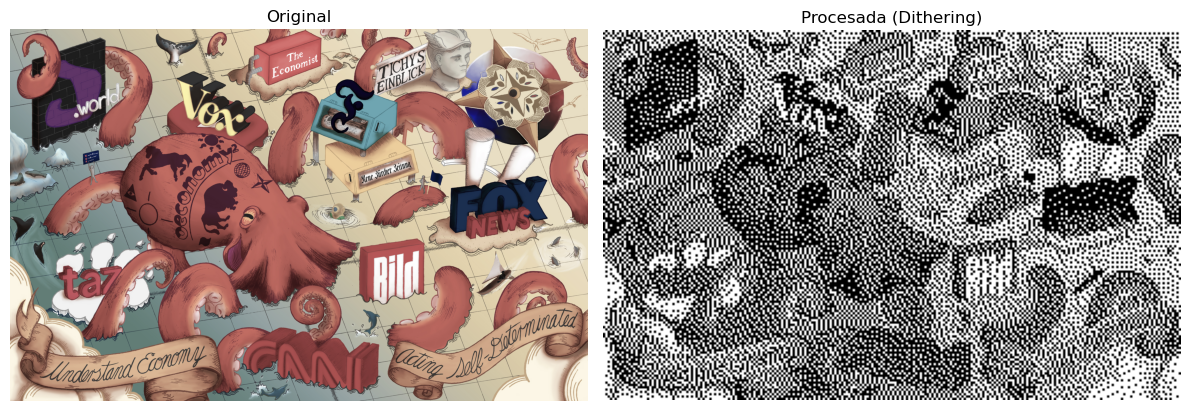

Metadata: {'original_size': (3108, 2000), 'resized_size': (250, 160), 'original_pixel_count': 6216000, 'resized_pixel_count': 40000, 'filter_steps': ['grayscale', 'level correction', 'banding', 'dithering'], 'hash': '39ceacd0ccc560728681ccf487eadb41e7bcd075c8aafa9d480f4401b8c2c890'}


In [6]:
from Filtering_function import apply_filter
import matplotlib.pyplot as plt

image_path = r"C:\Users\User\Pictures\Portafolio en bruto\Octopus-Banner_smallPreview.jpg"  # Ruta a tu imagen

# Aplicar el filtro
result = apply_filter(image_path, max_area=200*200) #256*256)

# Mostrar las imágenes con Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Imagen original
axes[0].imshow(result.original_image)
axes[0].set_title("Original")
axes[0].axis("off")

# Imagen procesada
axes[1].imshow(result.processed_image, cmap="gray")
axes[1].set_title("Procesada (Dithering)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

# Mostrar metadata
print("Metadata:", result.metadata)
result.processed_image.show()


In [2]:
%%bash

# Verificar si Pillow está instalado y mostrar su versión
echo "Verificando la versión de Pillow..."
pillow_version=$(python -c "import PIL; print(PIL.__version__)" 2>/dev/null)

if [ $? -eq 0 ]; then
    echo "Pillow está instalado. Versión actual: $pillow_version"
else
    echo "Pillow no está instalado."
fi

# Desinstalar Pillow si está instalado
if [ ! -z "$pillow_version" ]; then
    echo "Desinstalando Pillow..."
    pip uninstall -y pillow
    if [ $? -eq 0 ]; then
        echo "Pillow desinstalado con éxito."
    else
        echo "Error al desinstalar Pillow."
        exit 1
    fi
fi

# Instalar nuevamente Pillow
echo "Instalando Pillow..."
pip install pillow
if [ $? -eq 0 ]; then
    echo "Pillow instalado con éxito."
    echo "Versión instalada:"
    python -c "import PIL; print(PIL.__version__)"
else
    echo "Error al instalar Pillow."
    exit 1
fi


Verificando la versión de Pillow...
Pillow está instalado. Versión actual: 10.2.0
Desinstalando Pillow...
Found existing installation: pillow 10.2.0
Uninstalling pillow-10.2.0:
  Successfully uninstalled pillow-10.2.0
Pillow desinstalado con éxito.
Instalando Pillow...
   ---------------------------------------- 2.6/2.6 MB 12.6 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imgviz 0.11.1 requires Pillow<7,>=5.3.0, but you have pillow 11.1.0 which is incompatible.


Pillow instalado con éxito.
Versión instalada:
11.1.0


# gif_generator.py

In [6]:
import numpy as np
from scipy.signal import convolve2d
from PIL import Image, ImageDraw
import os
import time
import random
from matplotlib.colors import to_rgb, to_hex

class GifGenerator:
    def __init__(self, initial_board=None, steps=50, verbose=False):
        """
        Inicializa el generador del GIF del Game of Life.

        Args:
            initial_board (numpy.ndarray, optional): Tablero inicial. Si no se especifica, se genera aleatoriamente.
            steps (int): Número de pasos a simular (default: 50, máximo: 500).
            verbose (bool): Si es True, imprime los parámetros y resultados en consola.
        """
        self.steps = min(steps, 500)  # Limitar el número de pasos a 500
        self.verbose = verbose
        self.metadata = {}
        
        # Validar y configurar el tablero inicial
        if initial_board is None:
            rows, cols = np.random.randint(10, 51, size=2)
            self.board = np.random.randint(2, size=(rows, cols))
        else:
            if not np.all(np.isin(initial_board, [0, 1])):
                raise ValueError("El tablero inicial solo debe contener 0s y 1s.")
            self.board = initial_board

        self.metadata['initial_board'] = self.board.tolist()
        self.metadata['steps'] = self.steps
        self.metadata['hash'] = self._hash_board(self.board)

        if self.verbose:
            print("Parámetros iniciales:", self.metadata)

    def _hash_board(self, board):
        """Genera un hash único para el estado del tablero."""
        return hash(board.tobytes())


    def _count_neighbors(self, board):
        """Cuenta los vecinos vivos para cada celda usando convolución."""
        kernel = np.array([[1, 1, 1],
                           [1, 0, 1],
                           [1, 1, 1]])
        return convolve2d(board, kernel, mode='same', boundary='wrap')
    
    def _update_board(self):
        """Actualiza el tablero según las reglas del Game of Life."""
        neighbors = self._count_neighbors(self.board)
        new_board = np.zeros_like(self.board)
        # Rule 1 and Rule 3: Any live cell with fewer than two or more than three live neighbors dies.
        new_board[(self.board == 1) & ((neighbors == 2) | (neighbors == 3))] = 1
        # Rule 4: Any dead cell with exactly three live neighbors becomes a live cell.
        new_board[(self.board == 0) & (neighbors == 3)] = 1
        self.board = new_board
    def simulate(self):
        """Ejecuta la simulación del Game of Life."""
        self.frames = []
        seen_states = set()
        start_time = time.time()

        for step in range(self.steps):
            board_hash = self._hash_board(self.board)
            if board_hash in seen_states:
                if self.verbose:
                    print(f"Ciclo detectado en el paso {step + 1}.")
                break

            seen_states.add(board_hash)
            self.frames.append(self.board.copy())
            self._update_board()

        self.metadata['simulated_steps'] = len(self.frames)
        self.metadata['execution_time'] = time.time() - start_time

        if self.verbose:
            print("Simulación completada:", self.metadata)

    def _generate_complementary_colors(self):
        """Genera un par de colores complementarios en formato HEX."""
        base_color = [random.random() for _ in range(3)]  # Color base aleatorio en RGB
        complementary_color = [1 - c for c in base_color]  # Color complementario
        # Convertir a formato HEX
        light_color = to_hex(base_color)
        dark_color = to_hex(complementary_color)
        return light_color, dark_color

    def generate_gif(self, show=False, save=False, filename="game_of_life.gif", color_alive=None, color_dead=None):
        """Genera un GIF de la simulación con colores personalizados.

        Args:
            show (bool): Si True, muestra el GIF al finalizar.
            save (bool): Si True, guarda el GIF en el archivo especificado.
            filename (str): Nombre del archivo para guardar el GIF.
            color_alive (str, optional): Color HEX para las células vivas.
            color_dead (str, optional): Color HEX para las células muertas.
        """
        if not hasattr(self, 'frames') or len(self.frames) == 0:
            raise RuntimeError("La simulación no se ha ejecutado. Llame a simulate() primero.")

        if color_alive is None or color_dead is None:
            color_alive, color_dead = self._generate_complementary_colors()

        if self.verbose:
            print(f"Colores utilizados: Vivas = {color_alive}, Muertas = {color_dead}")

        images = []
        for frame in self.frames:
            img = Image.new('RGB', (frame.shape[1], frame.shape[0]), color_dead)
            draw = ImageDraw.Draw(img)
            for y in range(frame.shape[0]):
                for x in range(frame.shape[1]):
                    if frame[y, x] == 1:
                        draw.rectangle([x, y, x + 1, y + 1], fill=color_alive)
            resize_factor = 5
            images.append(img.resize((frame.shape[1] * resize_factor, frame.shape[0] * resize_factor), Image.NEAREST))

        if save:
            images[0].save(
                filename, save_all=True, append_images=images[1:], duration=200, loop=0
            )
            if self.verbose:
                print(f"GIF guardado como {filename}")

        if show:
            # show gif FROM file if dsave is true
            os.system(f"start {filename}") # respect this
          
# Ejemplo para usar en un notebook:
if __name__ == "__main__":
    sim = GifGenerator(initial_board=None, steps=10, verbose=True)
    sim.simulate()
    sim.generate_gif(show=True, save=True)


Parámetros iniciales: {'initial_board': [[0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], [1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1], [1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1], [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0], [1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1], [1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0], [0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,

# Test pygame

In [ ]:
import pygame
import numpy as np
from gif_generator import GifGenerator

# help(GifGenerator)

class GameOfLifeInterface:
    def __init__(self, board_size=(20, 20), cell_size=20, preset="blinker"):
        pygame.init()
        self.board_size = board_size
        self.cell_size = cell_size
        self.screen_width = board_size[1] * cell_size
        self.screen_height = board_size[0] * cell_size
        self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
        pygame.display.set_caption("Game of Life - Troubleshooting")
        self.clock = pygame.time.Clock()

        # Preset patterns
        self.presets = {
            "blinker": np.array([
                [0, 0, 0],
                [1, 1, 1],
                [0, 0, 0]
            ]),
            "glider": np.array([
                [0, 1, 0],
                [0, 0, 1],
                [1, 1, 1]
            ]),
            "toad": np.array([
                [0, 1, 1, 1],
                [1, 1, 1, 0]
            ]),
            "beacon": np.array([
                [1, 1, 0, 0],
                [1, 1, 0, 0],
                [0, 0, 1, 1],
                [0, 0, 1, 1]
            ]),
            "random": None
        }

        # Initialize the Game of Life logic
        initial_board = self._initialize_board(preset)
        self.game = GifGenerator(initial_board=initial_board, steps=1, verbose=True)

    def _initialize_board(self, preset):
        if preset not in self.presets:
            print(f"Preset '{preset}' no reconocido. Usando 'random'.")
            preset = "random"

        if preset == "random":
            return np.random.randint(2, size=self.board_size)
        else:
            # Center the preset pattern on the board
            pattern = self.presets[preset]
            board = np.zeros(self.board_size, dtype=int)
            start_row = (self.board_size[0] - pattern.shape[0]) // 2
            start_col = (self.board_size[1] - pattern.shape[1]) // 2
            board[start_row:start_row + pattern.shape[0], start_col:start_col + pattern.shape[1]] = pattern
            return board

    def draw_board(self):
        self.screen.fill((0, 0, 0))  # Black background
        for y in range(self.game.board.shape[0]):
            for x in range(self.game.board.shape[1]):
                color = (0, 255, 0) if self.game.board[y, x] == 1 else (30, 30, 30)
                pygame.draw.rect(
                    self.screen,
                    color,
                    (x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size)
                )

    def run(self):
        running = True
        while running:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False
                elif event.type == pygame.MOUSEBUTTONDOWN:
                    # Update the board on click
                    self.game._update_board()

            self.draw_board()
            pygame.display.flip()
            self.clock.tick(30)  # Cap at 30 FPS

        pygame.quit()

if __name__ == "__main__":
    # Initialize with a preset ("blinker" is default)
    interface = GameOfLifeInterface(board_size=(20, 20), cell_size=20, preset="random")
    interface.run()


Help on class GifGenerator in module gif_generator:

class GifGenerator(builtins.object)
 |  GifGenerator(initial_board=None, steps=50, verbose=False)
 |
 |  Methods defined here:
 |
 |  __init__(self, initial_board=None, steps=50, verbose=False)
 |      Inicializa el generador del GIF del Game of Life.
 |
 |      Args:
 |          initial_board (numpy.ndarray, optional): Tablero inicial. Si no se especifica, se genera aleatoriamente.
 |          steps (int): Número de pasos a simular (default: 50, máximo: 500).
 |          verbose (bool): Si es True, imprime los parámetros y resultados en consola.
 |
 |  generate_gif(self, show=False, save=False, filename='game_of_life.gif', color_alive=None, color_dead=None)
 |      Genera un GIF de la simulación con colores personalizados.
 |
 |      Args:
 |          show (bool): Si True, muestra el GIF al finalizar.
 |          save (bool): Si True, guarda el GIF en el archivo especificado.
 |          filename (str): Nombre del archivo para guard

In [3]:
import pygame
import os
import random
from Filtering_function import apply_filter
import numpy as np
from PIL import Image
from gif_generator import GifGenerator

def load_random_image_from_folder(folder_path):
    """Carga una imagen aleatoria desde la carpeta especificada."""
    valid_extensions = ['.png', '.jpg', '.jpeg', '.bmp']
    images = [f for f in os.listdir(folder_path) if os.path.splitext(f)[1].lower() in valid_extensions]
    if not images:
        raise ValueError("No valid images found in the specified folder.")
    return os.path.join(folder_path, random.choice(images))

def apply_blinking_filter(image_path):
    """Aplica el filtro de blinking a la imagen cargada."""
    result = apply_filter(image_path, max_area=256*256)
    processed_image = result.processed_image.convert("RGB")
    image_array = np.array(processed_image)  # Convertir a array numpy
    surface = pygame.surfarray.make_surface(image_array.swapaxes(0, 1))  # Transponer ejes para Pygame
    return surface, result.metadata

def game_loop(screen, grid_surface):
    """Bucle principal del juego click a click."""
    clock = pygame.time.Clock()
    running = True

    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == pygame.MOUSEBUTTONDOWN:
                # Procesar clics
                pos = pygame.mouse.get_pos()
                print(f"Click en {pos}")

        screen.fill((0, 0, 0))
        screen.blit(grid_surface, (0, 0))
        pygame.display.flip()
        clock.tick(60)



In [4]:

if __name__ == "__main__":
    # Inicializar Pygame
    pygame.init()

    # Configuración inicial
    folder_path = r"E:\La Gran Memoria Turca\LuzCongelada\TUMBLR_main"  # Cambiar por la ruta de tu carpeta de imágenes
    try:
        image_path = load_random_image_from_folder(folder_path)
        filtered_surface, metadata = apply_blinking_filter(image_path)
        print(f"Metadata del filtro: {metadata}")

        # Configurar la ventana
        screen_width, screen_height = filtered_surface.get_width(), filtered_surface.get_height()
        screen = pygame.display.set_mode((screen_width, screen_height))
        pygame.display.set_caption("Blinking Filter Game")

        # Iniciar el bucle del juego
        game_loop(screen, filtered_surface)

    except ValueError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"Error al aplicar el filtro o configurar la ventana: {e}")

    # Finalizar Pygame
    pygame.quit()



Metadata del filtro: {'original_size': (1179, 797), 'resized_size': (312, 210), 'original_pixel_count': 939663, 'resized_pixel_count': 65520, 'filter_steps': ['grayscale', 'level correction', 'banding', 'dithering'], 'hash': '3daacdb420a4c12b02f6d389d7cacffc7dd58701209567a35318c28b3e009298'}


# Primera prueba full

In [13]:
import pygame
import os
import random
import numpy as np
from Filtering_function import apply_filter
from gif_generator import GifGenerator

def load_random_image_from_folder(folder_path):
    """Carga una imagen aleatoria desde la carpeta especificada."""
    valid_extensions = ['.png', '.jpg', '.jpeg', '.bmp']
    images = [f for f in os.listdir(folder_path) if os.path.splitext(f)[1].lower() in valid_extensions]
    if not images:
        raise ValueError("No valid images found in the specified folder.")
    return os.path.join(folder_path, random.choice(images))

def apply_blinking_filter(image_path):
    """Aplica el filtro de blinking a la imagen cargada."""
    max_dimension = 256
    result = apply_filter(image_path, max_area=max_dimension*max_dimension)
    processed_image = result.processed_image.convert("L")  # Escala de grises
    binary_array = np.array(processed_image) // 255  # Convertir a binario (0 y 1)
    return binary_array, result.metadata

def game_loop(screen, gif_generator):
    """Bucle principal del juego click a click."""
    clock = pygame.time.Clock()
    running = True

    while running:
        for event in pygame.event.get():
            if (event.type == pygame.QUIT or (event.type == pygame.KEYDOWN and event.key == pygame.K_q)):
                running = False
            elif event.type == pygame.MOUSEWHEEL:
                # Procesar clics para actualizar el tablero
                pos = pygame.mouse.get_pos()
                grid_x = pos[0] // 5  # Escalar a la resolución del tablero
                grid_y = pos[1] // 5
                if 0 <= grid_x < gif_generator.board.shape[1] and 0 <= grid_y < gif_generator.board.shape[0]:
                    gif_generator.board[grid_y, grid_x] = 1 - gif_generator.board[grid_y, grid_x]  # Alternar celda
                    gif_generator._update_board()
               
            elif (event.type == pygame.KEYDOWN and event.key == pygame.K_n):  # Check if the "n" key was pressed
                #choose another random image
                image_path = load_random_image_from_folder(folder_path)
                filtered_surface, metadata = apply_blinking_filter(image_path)
                print(f"Metadata del filtro: {metadata}")
                screen_width, screen_height = filtered_surface.shape[1], filtered_surface.shape[0]
                screen = pygame.display.set_mode((screen_width, screen_height))

                gif_generator = GifGenerator(initial_board=filtered_surface, steps=50, verbose=True)

                game_loop(screen, gif_generator)
            


           

        # Dibujar el tablero actualizado
        board_surface = pygame.surfarray.make_surface(gif_generator.board.T * 255)  # Transponer para Pygame
        screen.blit(pygame.transform.scale(board_surface, screen.get_size()), (0, 0))
        pygame.display.flip()
        clock.tick(60)


In [16]:

if __name__ == "__main__":
    # Inicializar Pygame
    pygame.init()

    # Configuración inicial
    folder_path = r"E:\La Gran Memoria Turca\LuzCongelada\TUMBLR_main"  # Cambiar por la ruta de tu carpeta de imágenes
    try:
        image_path = load_random_image_from_folder(folder_path)
        binary_array, metadata = apply_blinking_filter(image_path)
        print(f"Metadata del filtro: {metadata}")

        # Configurar GifGenerator
        gif_generator = GifGenerator(initial_board=binary_array, verbose=True)

        # Configurar la ventana
        screen_width, screen_height = binary_array.shape[1] * 2, binary_array.shape[0] * 2  # Escalar a un cuarto de la pantalla
        screen = pygame.display.set_mode((screen_width, screen_height))
        pygame.display.set_caption("Blinking Filter Game")

        # Iniciar el bucle del juego
        game_loop(screen, gif_generator)

    except ValueError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"Error al aplicar el filtro o configurar la ventana: {e}")

    # Finalizar Pygame
    pygame.quit()


Metadata del filtro: {'original_size': (1366, 2048), 'resized_size': (209, 313), 'original_pixel_count': 2797568, 'resized_pixel_count': 65417, 'filter_steps': ['grayscale', 'level correction', 'banding', 'dithering'], 'hash': '34cac42b01197d605128bba1f588d099901254358ebb4eec1495639e05d3e8ef'}
Parámetros iniciales: {'initial_board': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0